In [64]:
import tensorflow as tf

In [65]:
!nvidia-smi

Thu Mar 31 13:39:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    59W / 149W |   8457MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [66]:
tf.__version__

'2.8.0'

In [67]:
import numpy as np
import scipy
from scipy import misc
import glob
from PIL import Image
import os
import matplotlib.pyplot as plt
import librosa
from tensorflow.keras import layers
from tensorflow.keras.layers import (Input, Add, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
#import pydot
from tensorflow.python.keras.utils import layer_utils
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import glorot_uniform
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
#from pydub import AudioSegment
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

In [5]:
train_dir = '/content/drive/MyDrive/Programs/train'
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(288,432),color_mode="rgb",class_mode='categorical',batch_size=128)

validation_dir = '/content/drive/MyDrive/Programs/test'
vali_datagen = ImageDataGenerator(rescale=1./255)
vali_generator = vali_datagen.flow_from_directory(validation_dir,target_size=(288,432),color_mode='rgb',class_mode='categorical',batch_size=128)


Found 8100 images belonging to 9 classes.
Found 900 images belonging to 9 classes.


In [6]:
next(train_generator)[0][0].shape

(288, 432, 3)

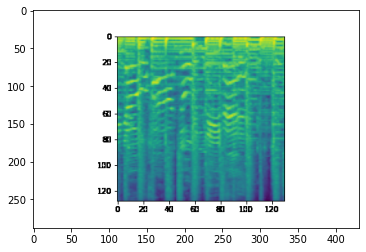

In [7]:
import matplotlib.pyplot as plt
plt.imshow(next(train_generator)[0][0])

In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Input
inp = Input(shape = next(train_generator)[0][0].shape)
model = ResNet50(
    include_top=False,
    weights="imagenet",
    
    classes=9,
    input_tensor = inp
)

94781440/94765736 [==============================] - 1s 0us/step


In [9]:
for layer in model.layers:
    layer.trainable=False

In [10]:
from tensorflow.keras.layers import BatchNormalization,Dropout,Conv2D
new_model = Sequential()

new_model.add(model)

new_model.add(Flatten())

new_model.add(BatchNormalization())
new_model.add(Dense(128, activation='relu'))
new_model.add(Dropout(0.5))

new_model.add(BatchNormalization())
new_model.add(Dense(64, activation='relu'))
new_model.add(Dropout(0.5))


new_model.add(Dense(9, activation='softmax'))

In [11]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 9, 14, 2048)       23587712  
                                                                 
 flatten (Flatten)           (None, 258048)            0         
                                                                 
 batch_normalization (BatchN  (None, 258048)           1032192   
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               33030272  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                        

In [12]:
new_model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [13]:
new_model.fit(train_generator,epochs=50,validation_data=vali_generator)

Epoch 1/50
64/64 [==============================] - 2607s 40s/step - loss: 1.9386 - accuracy: 0.3196 - val_loss: 2.4180 - val_accuracy: 0.1267
Epoch 2/50
64/64 [==============================] - 139s 2s/step - loss: 1.3727 - accuracy: 0.4943 - val_loss: 2.1247 - val_accuracy: 0.1656
Epoch 3/50
64/64 [==============================] - 139s 2s/step - loss: 1.1129 - accuracy: 0.5775 - val_loss: 1.7495 - val_accuracy: 0.3044
Epoch 4/50
64/64 [==============================] - 140s 2s/step - loss: 0.9568 - accuracy: 0.6373 - val_loss: 1.4087 - val_accuracy: 0.4011
Epoch 5/50
64/64 [==============================] - 139s 2s/step - loss: 0.8661 - accuracy: 0.6678 - val_loss: 1.3754 - val_accuracy: 0.4167
Epoch 6/50
64/64 [==============================] - 139s 2s/step - loss: 0.7935 - accuracy: 0.7000 - val_loss: 1.1817 - val_accuracy: 0.5389
Epoch 7/50
64/64 [==============================] - 140s 2s/step - loss: 0.7482 - accuracy: 0.7152 - val_loss: 0.8285 - val_accuracy: 0.7356
Epoch 8/50


In [15]:
!mkdir -p saved_model
new_model.save('/content/drive/MyDrive/Programs/pb_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Programs/pb_model/assets


In [16]:
new_model.save("/content/drive/MyDrive/Programs/h5_model", save_format="h5")

In [29]:
new_model.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

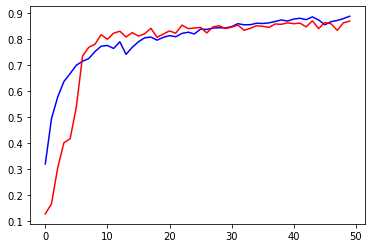

In [37]:
plt.plot(new_model.history.history['accuracy'],'b', new_model.history.history['val_accuracy'],'r')

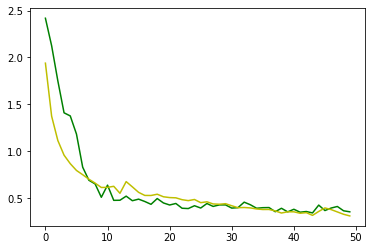

In [72]:
plt.plot(new_model.history.history['val_loss'],'g',new_model.history.history['loss'],'y')

In [39]:
transferlearning_model = tf.keras.models.load_model('/content/drive/MyDrive/Programs/pb_model')
# Check its architecture
transferlearning_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 9, 14, 2048)       23587712  
                                                                 
 flatten (Flatten)           (None, 258048)            0         
                                                                 
 batch_normalization (BatchN  (None, 258048)           1032192   
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               33030272  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                        

***Checking and verifiying Model For results***

In [41]:
genres_ordered =  'rock reggae pop metal hiphop disco country classical blues'

In [56]:
genres_ordered_prediction=genres_ordered.split(" ")

In [57]:
genres_ordered_prediction.reverse()

In [58]:
print(genres_ordered_prediction)

['blues', 'classical', 'country', 'disco', 'hiphop', 'metal', 'pop', 'reggae', 'rock']


In [82]:
img1 = image.load_img('/content/drive/MyDrive/Programs/Test Wav/melspectrogram.png',color_mode='rgb', target_size=(288,432,3))
img = image.img_to_array(img1)
img = img/255


In [83]:
img = np.expand_dims(img, axis=0)

In [84]:
prediction = transferlearning_model.predict(img, batch_size=None,steps=1) 

In [85]:
prediction

array([[1.3286838e-06, 9.9998546e-01, 1.2954768e-05, 1.9863917e-08,
        1.3105174e-09, 6.8328049e-10, 2.1609262e-08, 5.8410812e-08,
        8.4507803e-08]], dtype=float32)

In [86]:
print(f'The predicted genre of the song is : {genres_ordered_prediction[np.argmax(prediction)]}')

The predicted genre of the song is : classical
